Files already downloaded and verified
Epoch 1/5 完了
Epoch 2/5 完了
Epoch 3/5 完了
Epoch 4/5 完了
Epoch 5/5 完了


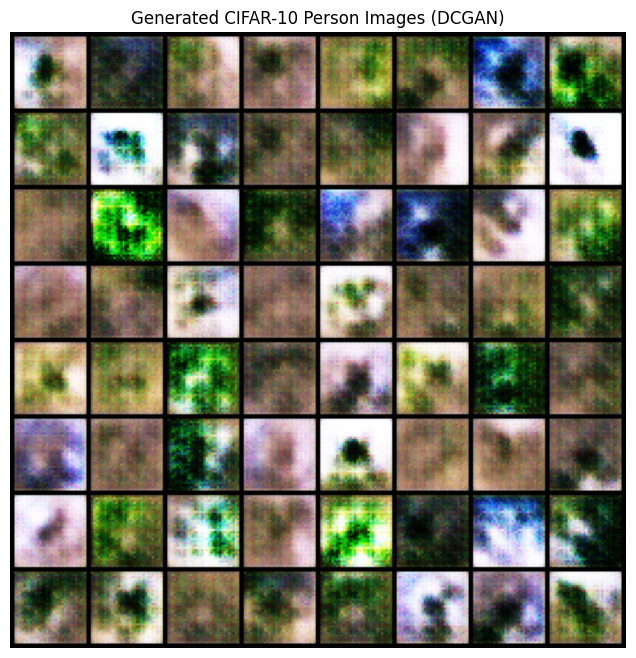

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10人物画像抽出
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1,1]に正規化
])

cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 人物クラス（CIFAR-10にはないので仮にbird=2を人物扱い）
person_class = 2
person_images = torch.stack([img for img, label in cifar10 if label == person_class])
person_dataset = torch.utils.data.TensorDataset(person_images)
dataloader = torch.utils.data.DataLoader(person_dataset, batch_size=64, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # 出力[-1,1]
        )

    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # 出力[0,1]
        )

    def forward(self, input):
        return self.main(input).view(-1)

# モデル初期化
nz = 100  # 潜在ベクトル次元
G = Generator(nz).to(device)
D = Discriminator().to(device)

# 損失関数 & 最適化
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 学習
epochs = 5
real_label, fake_label = 1., 0.

for epoch in range(epochs):
    for i, (data,) in enumerate(dataloader):
        data = data.to(device)
        b_size = data.size(0)

        ## 1. Discriminator更新
        D.zero_grad()
        output = D(data).view(-1)
        errD_real = criterion(output, torch.full((b_size,), real_label, device=device))
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = G(noise)
        output = D(fake.detach()).view(-1)
        errD_fake = criterion(output, torch.full((b_size,), fake_label, device=device))
        errD_fake.backward()
        optimizerD.step()

        ## 2. Generator更新
        G.zero_grad()
        output = D(fake).view(-1)
        errG = criterion(output, torch.full((b_size,), real_label, device=device))
        errG.backward()
        optimizerG.step()

    print(f"Epoch {epoch+1}/{epochs} 完了")

# 画像生成
with torch.no_grad():
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    fake_images = G(fixed_noise).detach().cpu()
    save_image(fake_images, 'dcgan_generated_persons.png', normalize=True, nrow=8)

# 表示
grid_img = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1,2,0))
plt.title('Generated CIFAR-10 Person Images (DCGAN)')
plt.axis('off')
plt.show()
